In [45]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import mapclassify

# Zoning dist

In [2]:
zones_2009 = gpd.read_file('zoning_data/Zoning_2009.geojson')

In [3]:
multifamily = {'R-M', 'R-M(PD)', 'R-M(CL)', 'R-2', 'R-2(PD)', 'UV', 'CP', 
               'CP(PD)', 'MUC', 'MUN', 'DC', 'DC-NT1', 'DC(PD)'}
sj_zips = gpd.read_file('Zip_Code_Boundary.geojson')

sj_zones = gpd.read_file('zoning_data/Zoning_2015.geojson').to_crs(sj_zips.crs)


def calculate_percentage(group):
    total = len(group)
    rm_rows = len(group[group['ZONINGABBREV'].isin(multifamily)])
    
    return rm_rows / total

joined_data = gpd.sjoin(sj_zips, sj_zones, how='inner', predicate='intersects')


percentages = (
    joined_data.groupby('ZIPCODE').apply(calculate_percentage)
    .reset_index(name='multifam_percentage')
)
joined_data = joined_data.merge(percentages, on = 'ZIPCODE', how = 'left')


KeyboardInterrupt: 

In [ ]:
abbrev_data = joined_data[['ZIPCODE', 'FACILITYID', 'ZONINGABBREV', 'multifam_percentage']] #would add total area here
abbrev_data['ZIPCODE'] = abbrev_data['ZIPCODE'].astype('int64')

In [ ]:
zones_2009 = zones_2009.to_crs(sj_zones.crs)


In [ ]:
base_joined = gpd.sjoin(sj_zips, zones_2009, how='inner', predicate='intersects')

base_percentages = (
    base_joined.groupby('ZIPCODE').apply(calculate_percentage)
    .reset_index(name='multifam_percentage_2009')
)


base_joined = base_joined.merge(base_percentages, on = 'ZIPCODE', how = 'left')


abbrev_base = base_joined[['ZIPCODE', 'FACILITYID', 'ZONINGABBREV', 'multifam_percentage_2009']]
abbrev_base['ZIPCODE'] = abbrev_base['ZIPCODE'].astype('int64')

In [ ]:
to_join_base = abbrev_base[['ZIPCODE', 'multifam_percentage_2009']].groupby('ZIPCODE').max()
to_join_final = abbrev_data[['ZIPCODE', 'multifam_percentage']].groupby('ZIPCODE').max() #would add total area


zip_panel = to_join_base.merge(to_join_final, how = 'inner', left_index = True, right_index = True)

In [ ]:

zip_panel['initial_diff'] = zip_panel['multifam_percentage'] - zip_panel['multifam_percentage_2009']


In [ ]:
zip_panel.hist(column = 'initial_diff', bins = 20)
plt.title('2009 to 2015')
#plt.show()
plt.savefig('09_15_diff.png')


# Histogram

In [20]:
df = pd.read_csv('new_full_data.csv')

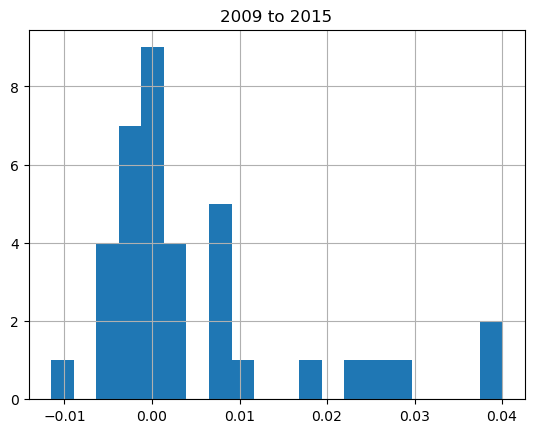

In [21]:
df.hist(column = 'initial_diff', bins = 20)
plt.title('2009 to 2015')

plt.savefig('plots/SJ_09_15_diff.png')
plt.show()


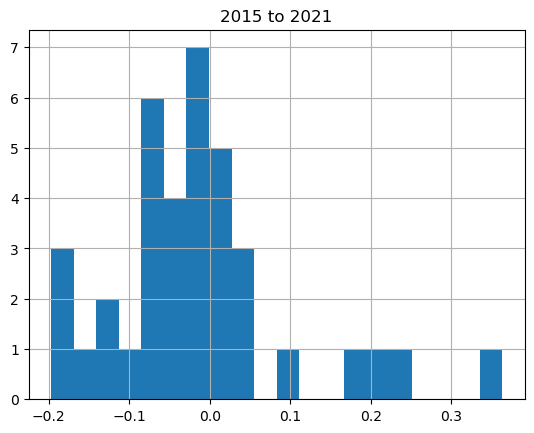

In [22]:
df.hist(column = 'final_diff', bins = 20)
plt.title('2015 to 2021')
plt.savefig('plots/SJ_15_21_diff.png')
plt.show()


# Zoning visualization

In [23]:
sj_zips = gpd.read_file('Zip_Code_Boundary.geojson')

In [24]:
sj_zips['ZIPCODE'] = sj_zips['ZIPCODE'].astype('int64')

In [25]:
merged = sj_zips.merge(df, left_on = 'ZIPCODE', right_on = 'ZIP')

In [21]:
#merged.columns

### Continuous color maps (ignore)

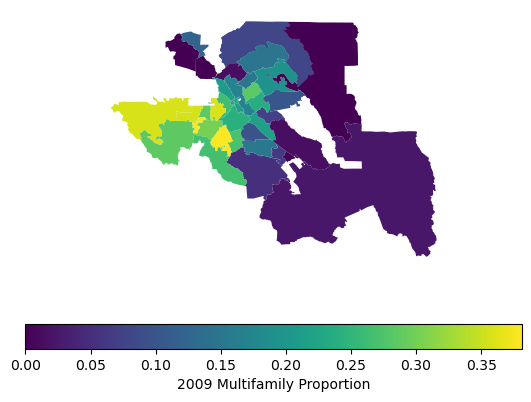

In [11]:
ax = merged.plot(column = 'multifam_percentage_2009', legend = True,
                legend_kwds={"label": "2009 Multifamily Proportion", "orientation": "horizontal"})
ax.set_axis_off()

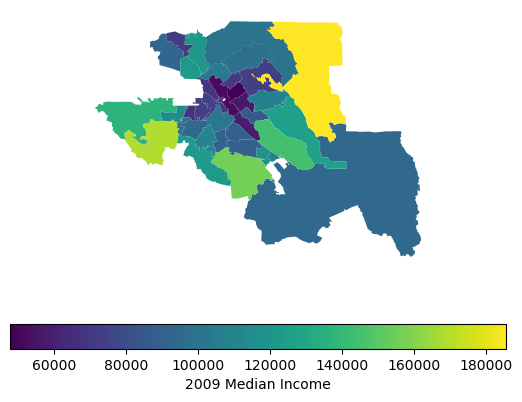

In [24]:
ax1 = merged.plot(column = 'Median income (dollars)', legend = True,
                 legend_kwds={"label": "2009 Median Income", "orientation": "horizontal"})
ax1.set_axis_off()

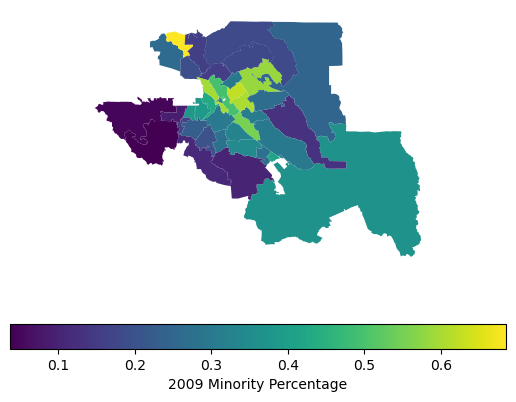

In [25]:
#install mapclassify to use scheme = 'quantiles', or exclude
ax2 = merged.plot(column = 'Minority', legend = True,
                 legend_kwds={"label": "2009 Minority Percentage", "orientation": "horizontal"})
ax2.set_axis_off()

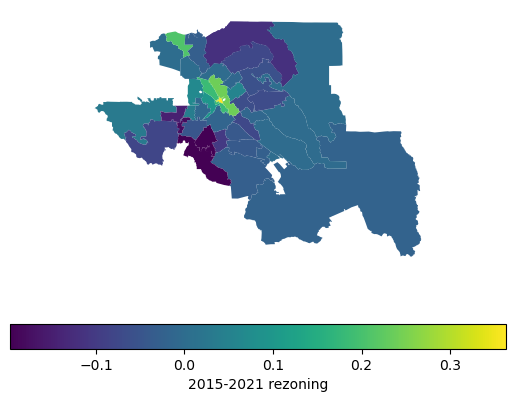

In [35]:
#install mapclassify to use scheme = 'quantiles', or exclude
ax3 = merged.plot(column = 'final_diff', legend = True,
                 legend_kwds={"label": "2015-2021 rezoning", "orientation": "horizontal"})
ax3.set_axis_off()

### Binned colormaps

In [12]:
#merged.columns

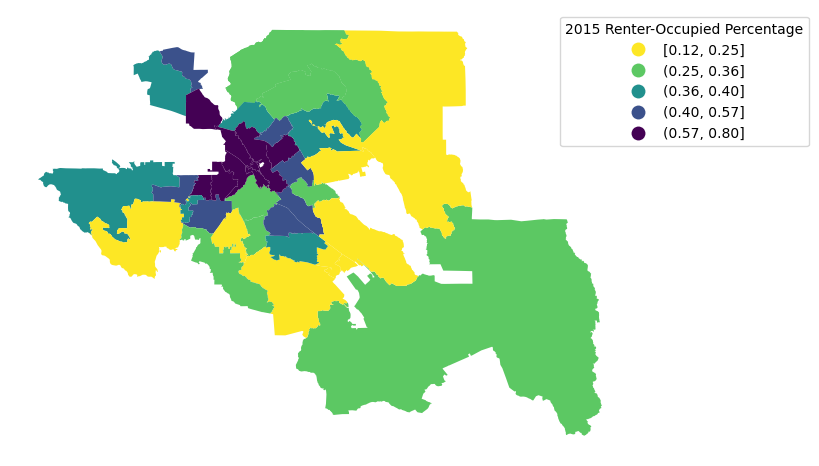

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

cmap = plt.colormaps['viridis']
reversed_cmap = cmap.reversed()

ax4 = merged.plot(column='Renter-occupied_pct', legend=True, 
                  scheme='quantiles', cmap=reversed_cmap, ax=ax)



# Customize the legend
legend = ax4.get_legend()
legend.set_title("2015 Renter-Occupied Percentage")
legend.set_bbox_to_anchor((1.3, 1))

q5 = mapclassify.Quantiles(merged['Renter-occupied_pct'], k=5)
mapping = dict([(i, s) for i, s in enumerate(q5.get_legend_classes())])

for i, txt in enumerate(legend.texts):
    txt.set_text(mapping[i])

ax4.set_axis_off()




# Save the plot
output_path = "plots/rent_pct_choro.png"

plt.savefig(output_path, dpi=300, bbox_inches='tight') 
plt.show()
plt.close()

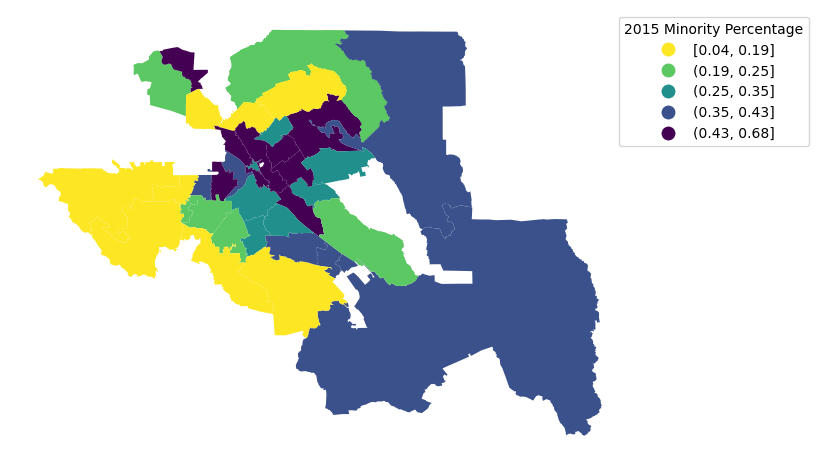

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

cmap = plt.colormaps['viridis']
reversed_cmap = cmap.reversed()

ax4 = merged.plot(column='Minority', legend=True, 
                  scheme='quantiles', cmap=reversed_cmap, ax=ax)



# Customize the legend
legend = ax4.get_legend()
legend.set_title("2015 Minority Percentage")
legend.set_bbox_to_anchor((1.3, 1))

q5 = mapclassify.Quantiles(merged['Minority'], k=5)
mapping = dict([(i, s) for i, s in enumerate(q5.get_legend_classes())])

for i, txt in enumerate(legend.texts):
    txt.set_text(mapping[i])

ax4.set_axis_off()




# Save the plot
output_path = "plots/minority_choro.png"

plt.savefig(output_path, dpi=300, bbox_inches='tight') 
plt.show()
plt.close()

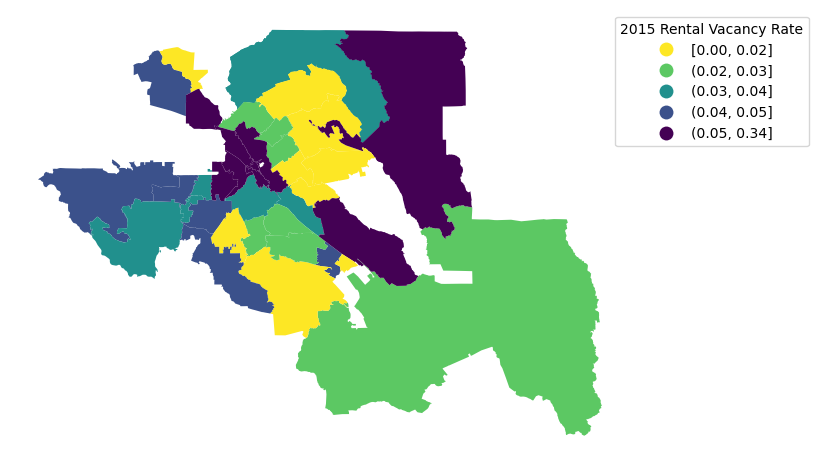

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

cmap = plt.colormaps['viridis']
reversed_cmap = cmap.reversed()

ax4 = merged.plot(column='Vacant housing units_pct', legend=True, 
                  scheme='quantiles', cmap=reversed_cmap, ax=ax)



# Customize the legend
legend = ax4.get_legend()
legend.set_title("2015 Rental Vacancy Rate")
legend.set_bbox_to_anchor((1.3, 1))

q5 = mapclassify.Quantiles(merged['Vacant housing units_pct'], k=5)
mapping = dict([(i, s) for i, s in enumerate(q5.get_legend_classes())])

for i, txt in enumerate(legend.texts):
    txt.set_text(mapping[i])

ax4.set_axis_off()




# Save the plot
output_path = "plots/vacant_units_choro.png"

plt.savefig(output_path, dpi=300, bbox_inches='tight') 
plt.show()
plt.close()

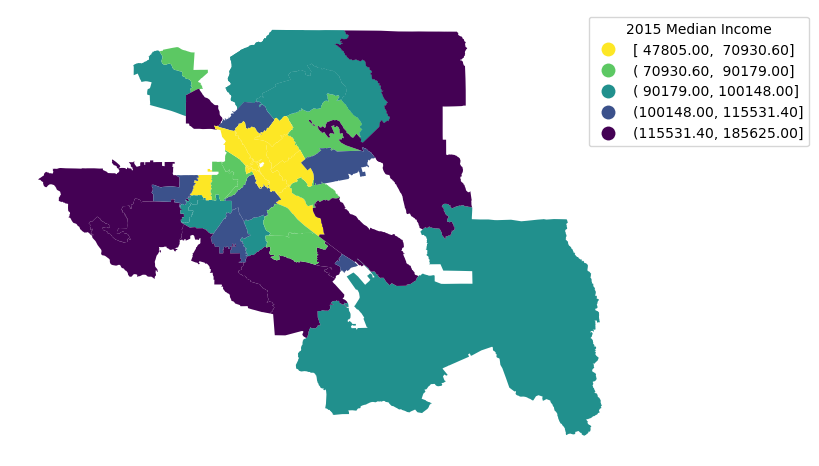

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

cmap = plt.colormaps['viridis']
reversed_cmap = cmap.reversed()

ax3 = merged.plot(column='Median income (dollars)', legend=True, 
                  scheme = 'quantiles',
                  cmap=reversed_cmap, ax=ax)



# Customize the legend
legend = ax3.get_legend()
legend.set_title("2015 Median Income")
legend.set_bbox_to_anchor((1.3, 1))

q5 = mapclassify.Quantiles(merged['Median income (dollars)'].astype(int), k=5)
mapping = dict([(i, s) for i, s in enumerate(q5.get_legend_classes())])

for i, txt in enumerate(legend.texts):
    txt.set_text(mapping[i])

ax3.set_axis_off()




# Save the plot
output_path = "plots/median_inc_choro.png"

plt.savefig(output_path, dpi=300, bbox_inches='tight') 
plt.show()
plt.close()

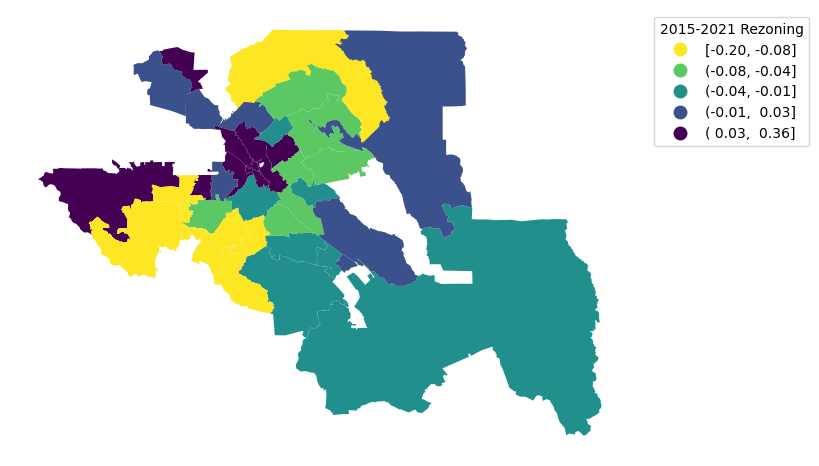

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

cmap = plt.colormaps['viridis']
reversed_cmap = cmap.reversed()

ax4 = merged.plot(column='final_diff', legend=True, 
                  scheme='quantiles', cmap=reversed_cmap, ax=ax)



# Customize the legend
legend = ax4.get_legend()
legend.set_title("2015-2021 Rezoning")
legend.set_bbox_to_anchor((1.3, 1))

q5 = mapclassify.Quantiles(merged['final_diff'], k=5)
mapping = dict([(i, s) for i, s in enumerate(q5.get_legend_classes())])

for i, txt in enumerate(legend.texts):
    txt.set_text(mapping[i])

ax4.set_axis_off()




# Save the plot
output_path = "plots/final_diff_choro.png"

plt.savefig(output_path, dpi=300, bbox_inches='tight') 
plt.show()
plt.close()

## Housing units 

In [46]:
demo.sort_values(by = 'change housing', ascending = False)

,OBJECTID,ZIPCODE,LASTUPDATE,SHAPE_Length,SHAPE_Area,SANJOSELIMITS,geometry,Unnamed: 0,multifam_percentage_2009,multifam_percentage_2015,...,change mean income,change housing,zipcode,0BR_base,1BR_base,2BR_base,3BR_base,4BR_base,log_0br_base,log_med_income_base
7,5225,95035,2021-08-05 17:48:02+00:00,262204.209859,1.263201e+09,No,"POLYGON ((-121.83136 37.48427, -121.83271 37.4...",5,0.080000,0.120000,...,58282.0,3244.0,95035,1556.8,1814.4,2318.4,3270.4,3987.2,7.350388,11.514404
18,5243,95123,2021-08-04 19:21:35+00:00,90892.105346,2.233042e+08,Yes,"POLYGON ((-121.84184 37.25902, -121.84281 37.2...",20,0.152838,0.150862,...,41113.0,2373.0,95123,1601.6,1870.4,2385.6,3360.0,4110.4,7.378758,11.399902
5,5219,95008,2021-07-29 18:02:54+00:00,82288.870242,1.784216e+08,Yes,"POLYGON ((-121.94034 37.29805, -121.94044 37.2...",2,0.301370,0.324324,...,55291.0,1269.0,95008,1310.4,1534.4,1960.0,2766.4,3371.2,7.178088,11.448014
33,5268,95112,2021-08-05 16:25:55+00:00,140291.948618,1.935390e+08,Yes,"MULTIPOLYGON (((-121.89279 37.34059, -121.8935...",11,0.168367,0.171149,...,34507.0,1260.0,95112,1075.2,1254.4,1601.6,2262.4,2755.2,6.980262,10.859172
8,5226,95037,2021-08-05 20:27:26+00:00,667727.883815,6.618384e+09,Yes,"MULTIPOLYGON (((-121.76040 37.18060, -121.7604...",6,0.022727,0.021277,...,45551.0,1218.0,95037,1366.4,1601.6,2038.4,2878.4,3505.6,7.219935,11.448238
3,5212,94089,2021-07-26 23:09:57+00:00,92487.546709,3.365182e+08,No,"POLYGON ((-121.98019 37.42296, -121.97860 37.4...",0,0.000000,0.000000,...,77018.0,1118.0,94089,1545.6,1814.4,2307.2,3259.2,3976.0,7.343167,11.437792
28,5256,95136,2021-07-27 18:26:46+00:00,64213.527747,1.547455e+08,Yes,"POLYGON ((-121.87657 37.26350, -121.87651 37.2...",31,0.097701,0.097826,...,47184.0,1022.0,95136,1400.0,1635.2,2083.2,2934.4,3584.0,7.244228,11.401647
21,5246,95126,2021-07-29 19:55:01+00:00,77019.934986,9.237028e+07,Yes,"POLYGON ((-121.92578 37.32918, -121.92578 37.3...",23,0.263844,0.266667,...,53957.0,892.0,95126,1187.2,1388.8,1769.6,2497.6,3046.4,7.079353,11.215476
27,5253,95133,2021-08-20 21:31:30+00:00,63447.389569,8.923537e+07,Yes,"POLYGON ((-121.84650 37.38873, -121.84660 37.3...",30,0.148936,0.146853,...,51767.0,852.0,95133,1153.6,1344.0,1713.6,2419.2,2945.6,7.050643,11.163708
32,5267,95110,2021-08-05 16:25:43+00:00,125080.893238,1.272895e+08,Yes,"MULTIPOLYGON (((-121.88490 37.32859, -121.8849...",9,0.209302,0.216814,...,62841.0,833.0,95110,1288.0,1512.0,1926.4,2721.6,3315.2,7.160846,11.145623


In [35]:
demo = pd.read_csv('demographic_changes.csv')

In [42]:
demo['ZIP base'].nunique()

35

In [41]:
demo['ZIP 2021'].nunique()

35

In [43]:
demo = sj_zips.merge(demo, left_on = 'ZIPCODE', right_on = 'ZIP 2021')

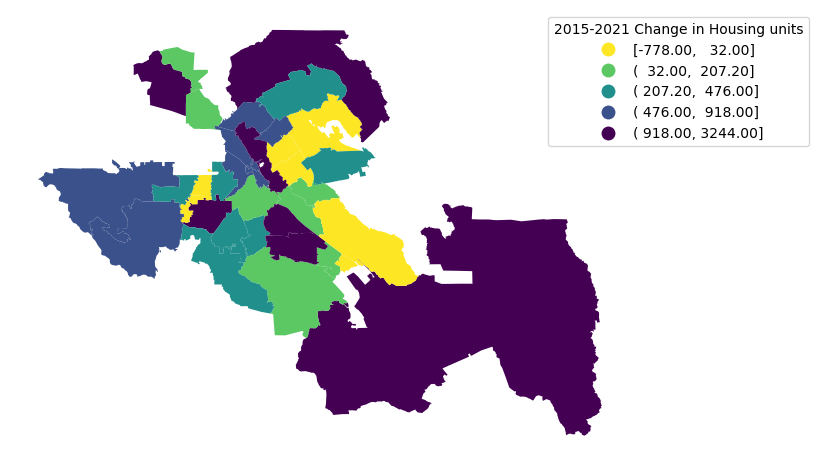

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

cmap = plt.colormaps['viridis']
reversed_cmap = cmap.reversed()

ax4 = demo.plot(column='change housing', legend=True, 
                  scheme='quantiles', cmap=reversed_cmap, ax=ax)



# Customize the legend
legend = ax4.get_legend()
legend.set_title("2015-2021 Change in Housing units")
legend.set_bbox_to_anchor((1.3, 1))

q5 = mapclassify.Quantiles(demo['change housing'], k=5)
mapping = dict([(i, s) for i, s in enumerate(q5.get_legend_classes())])

for i, txt in enumerate(legend.texts):
    txt.set_text(mapping[i])

ax4.set_axis_off()




# Save the plot

plt.savefig("plots/housing_diff_choro.png", dpi=300, bbox_inches='tight') 
plt.show()
plt.close()

**Extra**

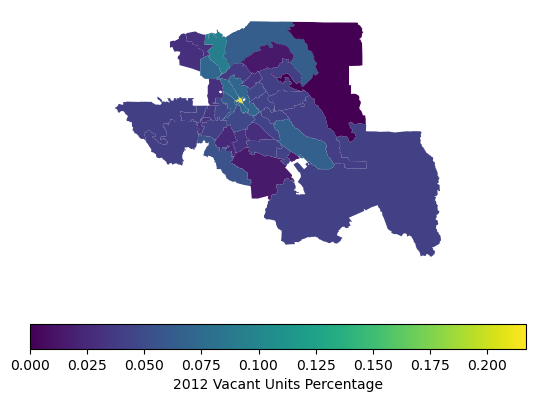

In [44]:
#install mapclassify to use scheme = 'quantiles', or exclude
ax4 = merged.plot(column = 'Vacant housing units_pct', legend = True,
                 legend_kwds={"label": "2012 Vacant Units Percentage", "orientation": "horizontal"})
ax4.set_axis_off()

In [28]:
merged.columns

Index(['OBJECTID', 'ZIPCODE', 'LASTUPDATE', 'SHAPE_Length', 'SHAPE_Area',
       'SANJOSELIMITS', 'geometry', 'ZIP', 'multifam_percentage_2012',
       'multifam_percentage_2015', 'multifam_percentage', 'initial_diff',
       'final_diff', '0BR_change', '1BR_change', '2BR_change', '3BR_change',
       '4BR_change', 'log_0BR_change', 'log_1BR_change', 'log_2BR_change',
       'log_3BR_change', 'log_4BR_change', '0BR_base', '1BR_base', '2BR_base',
       '3BR_base', '4BR_base', 'Male', 'White', 'Black or African American',
       'American Indian and Alaska Native', 'Asian',
       'Native Hawaiian and Other Pacific Islander',
       'Hispanic or Latino (of any race)', 'Total population',
       'Median age (years)', 'Total housing units', 'Median income (dollars)',
       'Mean income (dollars)', 'Density per unit', 'Minority',
       'Occupied housing units_pct', 'Vacant housing units_pct',
       'Renter-occupied_pct', 'Occupied housing units', 'Vacant housing units',
       'Rental v

# Data Exploration

In [8]:
df = pd.read_csv('full_data.csv')

In [3]:
df.columns

Index(['ZIP', 'multifam_percentage_2012', 'multifam_percentage_2015',
       'multifam_percentage', 'initial_diff', 'final_diff', '0BR_change',
       '1BR_change', '2BR_change', '3BR_change', '4BR_change', 'Male', 'White',
       'Black or African American', 'American Indian and Alaska Native',
       'Asian', 'Native Hawaiian and Other Pacific Islander',
       'Hispanic or Latino (of any race)', 'Median age (years)',
       'Total housing units', 'Median income (dollars)',
       'Mean income (dollars)'],
      dtype='object')

In [4]:
indep = ['initial_diff', 'final_diff',
       'Male', 'White', 'Black or African American',
       'American Indian and Alaska Native', 'Asian', 
       'Native Hawaiian and Other Pacific Islander', 'Hispanic or Latino (of any race)',
       'Median age (years)', 'Total housing units', 'Mean income (dollars)']

In [5]:
y_0 = df['0BR_change']

# 0br change 

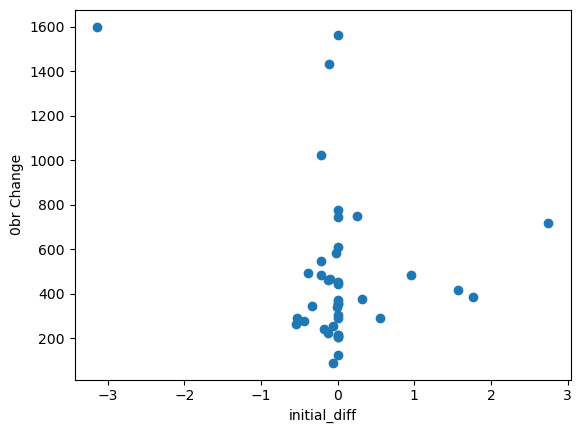

The correlation between 0br_change and initial_diff is: -0.26271370806527117


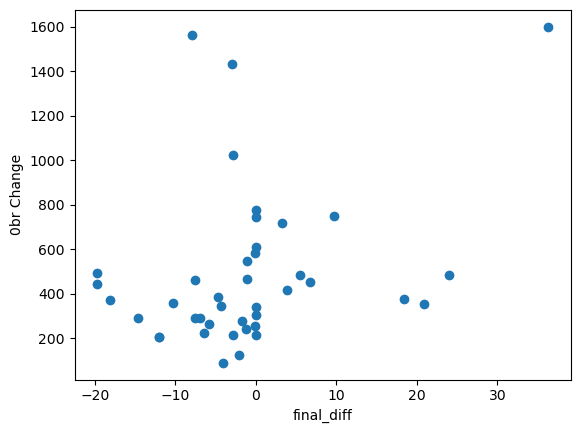

The correlation between 0br_change and final_diff is: 0.3207642644092664


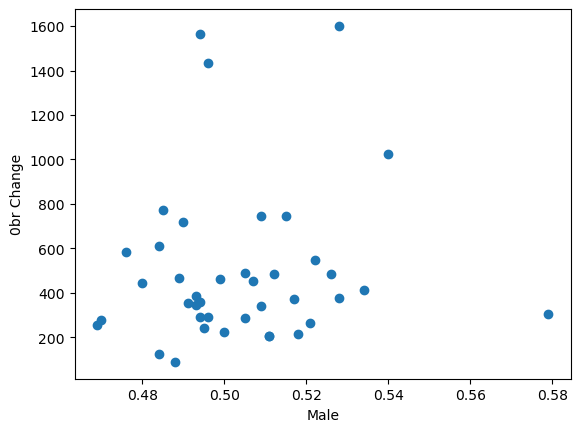

The correlation between 0br_change and Male is: 0.09959671232323905


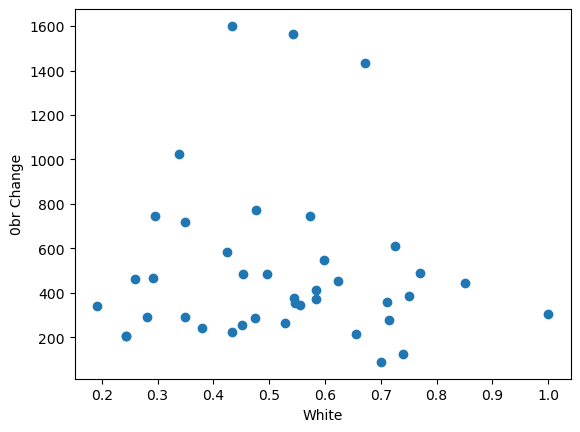

The correlation between 0br_change and White is: -0.05008037816205716


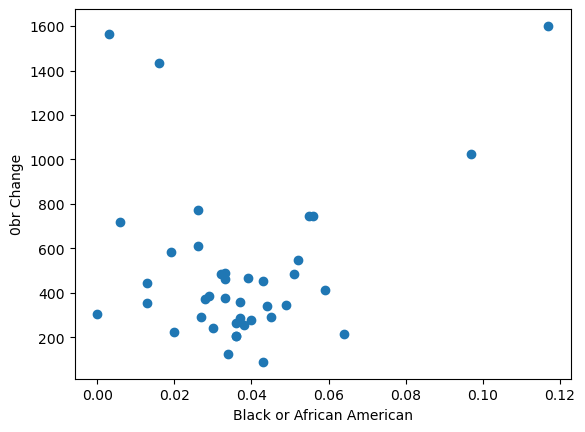

The correlation between 0br_change and Black or African American is: 0.22290275921359634


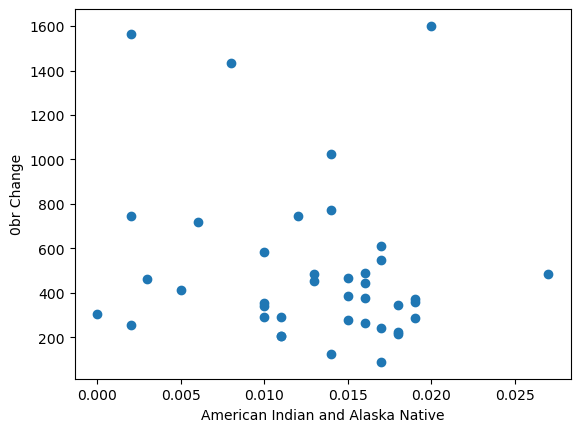

The correlation between 0br_change and American Indian and Alaska Native is: -0.17425100783604142


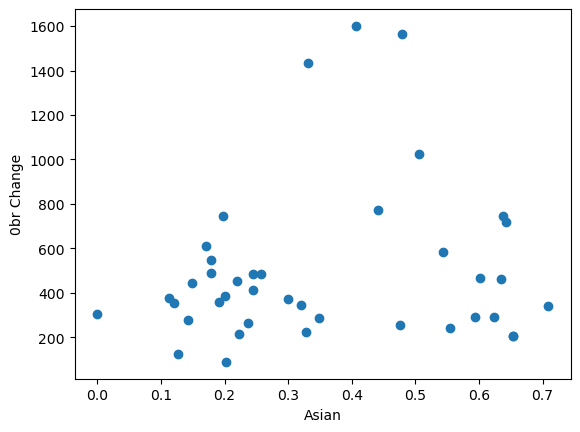

The correlation between 0br_change and Asian is: 0.14463707305055498


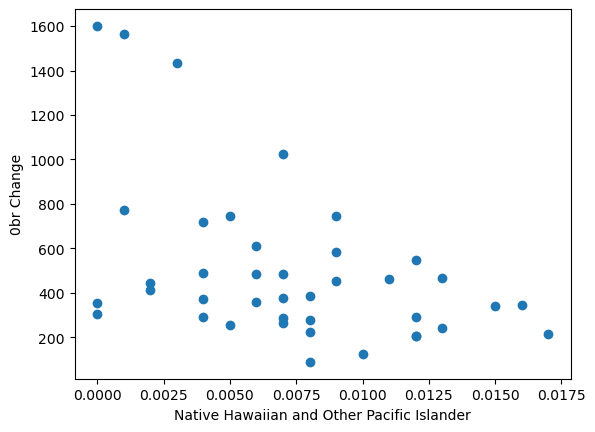

The correlation between 0br_change and Native Hawaiian and Other Pacific Islander is: -0.4597061368817334


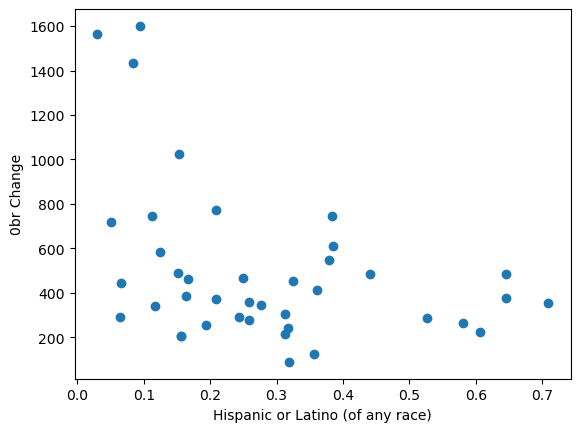

The correlation between 0br_change and Hispanic or Latino (of any race) is: -0.3963687708634041


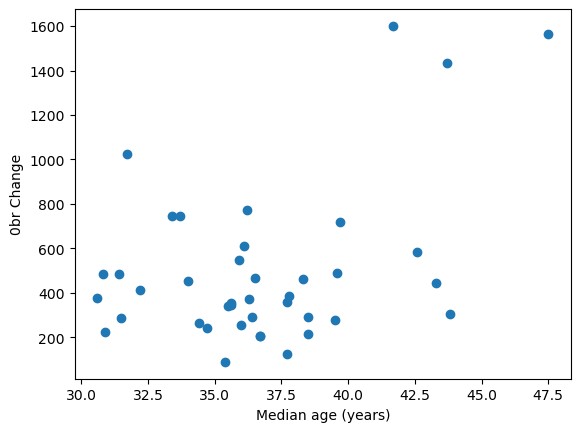

The correlation between 0br_change and Median age (years) is: 0.41590185993559886


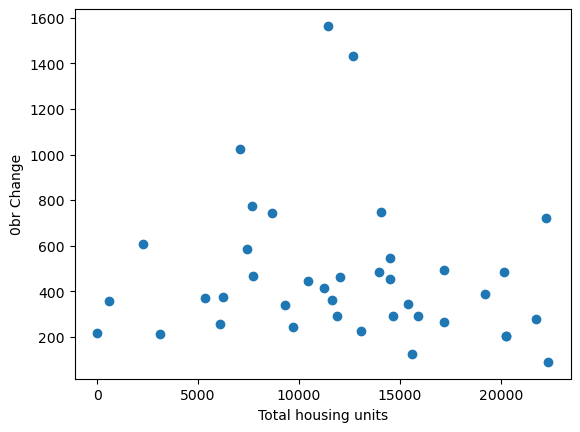

The correlation between 0br_change and Total housing units is: -0.1122950155567014


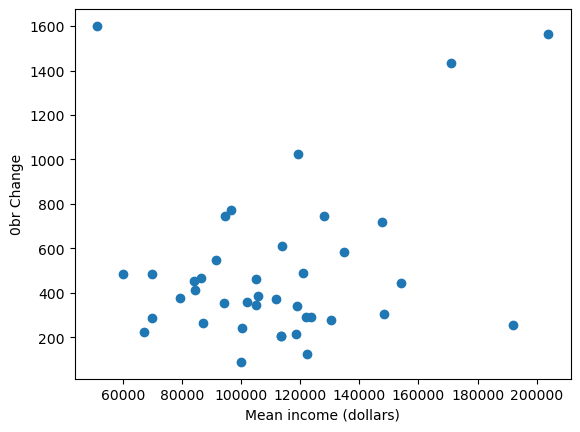

The correlation between 0br_change and Mean income (dollars) is: 0.2196065429625597


In [6]:
for var in indep:
    
    plt.scatter(y = df['0BR_change'], x = df[var])
    plt.ylabel('0br Change')
    plt.xlabel(var)
    plt.show()
    print(f"The correlation between 0br_change and {var} is: {df['0BR_change'].corr(df[var])}")

In [25]:
interaction = df['Median age (years)']* df['Mean income (dollars)']

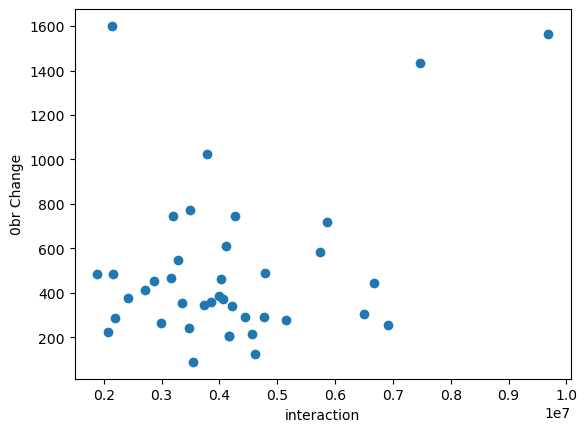

In [27]:
plt.scatter(y = df['0BR_change'], x = interaction)
plt.ylabel('0br Change')
plt.xlabel('interaction')
plt.show()